In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
from statistics import mean
import matplotlib.pyplot as plt

In [85]:
# ------------------------------- setting start ------------------------------ #
# color
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
errorbar_color = "#3A3A3A"

# font
csfont = {'family':'Times New Roman', 'serif': 'Times' , 'size' : 23}
plt.rc('text', usetex=True)
plt.rc('font', **csfont)

# bar plot size
bar_width = 0.4
bar_btw_space = 0.04
bar_space = 0.2

# errorbar plot size
err_lw=1.5
err_capsize=4
err_capthick=1.5

# set fig size
figsize=(6.4, 4.8)
# -------------------------------- setting end ------------------------------- #

In [ ]:
def read_original_results():
    aov = 70
    model = "LLaVA_05"
    scene = "AU"
    seq = "01"
    semantic = 1
    
    input_path = Path(f"./eva_results/{aov}_{model}/{scene}/{seq}/pred_{scene}_{seq}_questions_mcq.jsonl")

    df = pd.read_json(input_path, lines=True)
    
    cols_to_keep = ["qid_number", "question_type", "trigger_type", "bool_ans", "llm_ms"]
    df["bool_ans"] = (df["answer"] == df["predicted_answer_raw"]).astype(int)
    df["aov"] = aov
    df["model"] = model
    df["scene"] = scene
    df["seq"] = seq
    
    df = df[cols_to_keep]
    
    print(df.head())
    print(df["bool_ans"].mean())
    
    return df, df["bool_ans"].mean()

read_original_results()   

In [198]:
# ---------------------------------------------------------------------------- #
#                                   Semantic                                   #
# ---------------------------------------------------------------------------- #
def read_original_for_semantic():
    save_path = Path(".")/"results_semantic.csv"
    
    df_all = pd.DataFrame()
    
    # models = ["LLaVA_05", "LLaVA_7", "minicpmo", "qwen", "qwen3"]
    semantic_folder_names = ["eva_results", "eva_results_without_map"]
    models = ["LLaVA_7", "minicpmo", "qwen", "qwen3"]
    aovs = [360]
    scenes = ["AU", "CUA", "GMU", "GTown", "GTown2", "GWU", "Marymount", "NOVA", "UDC"]
    
    for semantic_folder_name in semantic_folder_names:
        for model in models:
            for aov in aovs:
                for scene in scenes:
                    df = pd.DataFrame()
                    if scene == "GMU":
                        for base_dir in (Path(f".")/f"{semantic_folder_name}"/f"{aov}_{model}"/f"{scene}").iterdir():
                            for d in base_dir.iterdir():
                                seq = d.name
                                input_path = base_dir/f"{seq}"/f"pred_{scene}_{base_dir.name}_{seq}_questions_mcq.jsonl"
                                # print(input_path)
                                df_tmp = pd.read_json(input_path, lines=True)[:-1]
                                # cols_to_keep = ["qid_number", "question_type", "trigger_type", "bool_ans", "llm_ms"]
                                cols_to_keep = ["qid_number", "bool_ans", "llm_ms"]
                                df_tmp["bool_ans"] = (df_tmp["answer"] == df_tmp["predicted_answer_raw"]).astype(int)
                                df_tmp = df_tmp[cols_to_keep]
                                
                                df_tmp["aov"] = aov
                                df_tmp["model"] = model
                                df_tmp["scene"] = scene
                                df_tmp["seq"] = int(seq)
                                # df_tmp["acc"] = df_tmp["bool_ans"].mean()
                                if semantic_folder_name == "eva_results":
                                    df_tmp["semantic"] = 1
                                else:
                                    df_tmp["semantic"] = 0
                                    
                                df = pd.concat([df, df_tmp], ignore_index=True)
                    else:
                        base_dir = Path(f".")/f"{semantic_folder_name}"/f"{aov}_{model}"/f"{scene}"
                        for d in base_dir.iterdir():
                            seq = d.name
                            input_path = base_dir/f"{seq}"/f"pred_{scene}_{seq}_questions_mcq.jsonl"
                            # print(input_path)
                            df_tmp = pd.read_json(input_path, lines=True)[:-1]
                            # cols_to_keep = ["qid_number", "question_type", "trigger_type", "bool_ans", "llm_ms"]
                            cols_to_keep = ["qid_number", "bool_ans", "llm_ms"]
                            df_tmp["bool_ans"] = (df_tmp["answer"] == df_tmp["predicted_answer_raw"]).astype(int)
                            df_tmp = df_tmp[cols_to_keep]
                            
                            df_tmp = df_tmp[df_tmp["qid_number"]==1]
                            
                            df_tmp["aov"] = aov
                            df_tmp["model"] = model
                            df_tmp["scene"] = scene
                            df_tmp["seq"] = int(seq)
                            if semantic_folder_name == "eva_results":
                                df_tmp["semantic"] = 1
                            else:
                                df_tmp["semantic"] = 0
                            
                            df = pd.concat([df, df_tmp], ignore_index=True)
                            
                    df["acc"] = df["bool_ans"].mean()
                    df_all = pd.concat([df_all, df], ignore_index=True)
    df_all.to_csv(save_path, index=False)
                
read_original_for_semantic() 

/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


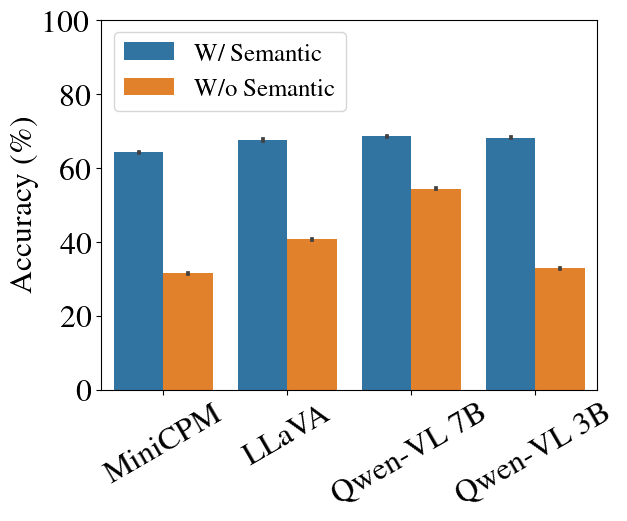

In [214]:
# ---------------------------------------------------------------------------- #
#                                   Semantic                                   #
# ---------------------------------------------------------------------------- #
def plot_semantic():
    saveDir = Path(".")/"figs"/f"semantic"
    saveDir.mkdir(parents=True, exist_ok=True)
    
    filePath = Path(".")/"results_semantic.csv"
    df = pd.read_csv(filePath)
    
    # Step 1: change to plotting format and filter
    df_plot = df
    df_plot["acc"] = df_plot["acc"] * 100
    # ["LLaVA_7", "minicpmo", "qwen", "qwen3"]
    df_plot['model'] = df_plot['model'].replace(['LLaVA_7'], 'MiniCPM')
    df_plot['model'] = df_plot['model'].replace(['minicpmo'], 'LLaVA')
    df_plot['model'] = df_plot['model'].replace(['qwen3'], 'Qwen-VL 3B')
    df_plot['model'] = df_plot['model'].replace(['qwen'], 'Qwen-VL 7B')
    model_order = ['MiniCPM', 'LLaVA', 'Qwen-VL 7B', 'Qwen-VL 3B']
    df_plot['model'] = pd.Categorical(df_plot['model'], categories=model_order, ordered=True)
    
    df_plot['semantic'] = df_plot['semantic'].replace([0], 'W/o Semantic')
    df_plot['semantic'] = df_plot['semantic'].replace([1], 'W/ Semantic')
    semantic_order = ['W/ Semantic', 'W/o Semantic']
    df_plot['semantic'] = pd.Categorical(df_plot['semantic'], categories=semantic_order, ordered=True)
    
    # print(df_plot)
    
    # 畫 lineplot
    ax = sns.barplot(x='model', y='acc',
                    hue= "semantic", hue_order=semantic_order,
                    data=df_plot, 
                    errorbar=('ci', 95), 
                    palette=color_palette
                    )
    
    ax.set(ylim = (0, 100))
    # plt.title("Text Retrieval ASR vs Recall Metric")
    plt.xlabel("")
    plt.ylabel(r"Accuracy (\%)")
    # plt.xticks([70, 110, 180, 360])  # 固定 X 軸刻度
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="center")
    plt.legend(title='', loc='upper left', fontsize="18", ncol=1, markerscale=2)
    
    plt.savefig(f'{saveDir}/semantic.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{saveDir}/semantic.eps', dpi=300, bbox_inches='tight')
    plt.show()
    
plot_semantic() 

In [62]:
# ---------------------------------------------------------------------------- #
#                             For the Q&A template                             #
# ---------------------------------------------------------------------------- #
def read_original_for_template(question_id):
    save_path = Path(".")/"results_template_question.csv"
    
    df_all = pd.DataFrame()
    
    # models = ["LLaVA_05", "LLaVA_7", "minicpmo", "qwen", "qwen3"]
    models = ["LLaVA_7", "minicpmo", "qwen", "qwen3"]
    aovs = [360, 180, 110, 70]
    scenes = ["AU", "CUA", "GMU", "GTown", "GTown2", "GWU", "Marymount", "NOVA", "UDC"]
    for model in models:
        for aov in aovs:
            df = pd.DataFrame()
            for scene in scenes:
                if scene == "GMU":
                    for base_dir in (Path(f".")/"eva_results"/f"{aov}_{model}"/f"{scene}").iterdir():
                        for d in base_dir.iterdir():
                            seq = d.name
                            input_path = base_dir/f"{seq}"/f"pred_{scene}_{base_dir.name}_{seq}_questions_mcq.jsonl"
                            df_tmp = pd.read_json(input_path, lines=True)[:-1]
                            # cols_to_keep = ["qid_number", "question_type", "trigger_type", "bool_ans", "llm_ms"]
                            cols_to_keep = ["qid_number", "bool_ans", "llm_ms"]
                            df_tmp["bool_ans"] = (df_tmp["answer"] == df_tmp["predicted_answer_raw"]).astype(int)
                            df_tmp = df_tmp[cols_to_keep]
                            
                            df_tmp = df_tmp[df_tmp["qid_number"]==question_id]
                            
                            df_tmp["aov"] = aov
                            df_tmp["model"] = model
                            df_tmp["scene"] = scene
                            df_tmp["seq"] = int(seq)
                            # df_tmp["acc"] = df_tmp["bool_ans"].mean()
                            
                            df = pd.concat([df, df_tmp], ignore_index=True)
                else:
                    base_dir = Path(f".")/"eva_results"/f"{aov}_{model}"/f"{scene}"
                    for d in base_dir.iterdir():
                        seq = d.name
                        input_path = base_dir/f"{seq}"/f"pred_{scene}_{seq}_questions_mcq.jsonl"
                        df_tmp = pd.read_json(input_path, lines=True)[:-1]
                        # cols_to_keep = ["qid_number", "question_type", "trigger_type", "bool_ans", "llm_ms"]
                        cols_to_keep = ["qid_number", "bool_ans", "llm_ms"]
                        df_tmp["bool_ans"] = (df_tmp["answer"] == df_tmp["predicted_answer_raw"]).astype(int)
                        df_tmp = df_tmp[cols_to_keep]
                        
                        df_tmp = df_tmp[df_tmp["qid_number"]==1]
                        
                        df_tmp["aov"] = aov
                        df_tmp["model"] = model
                        df_tmp["scene"] = scene
                        df_tmp["seq"] = int(seq)
                        # df_tmp["acc"] = df_tmp["bool_ans"].mean()
                        
                        df = pd.concat([df, df_tmp], ignore_index=True)
                        
            df["acc"] = df["bool_ans"].mean()
            df_all = pd.concat([df_all, df], ignore_index=True)
    df_all.to_csv(save_path, index=False)
                
read_original_for_template(1) 

/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

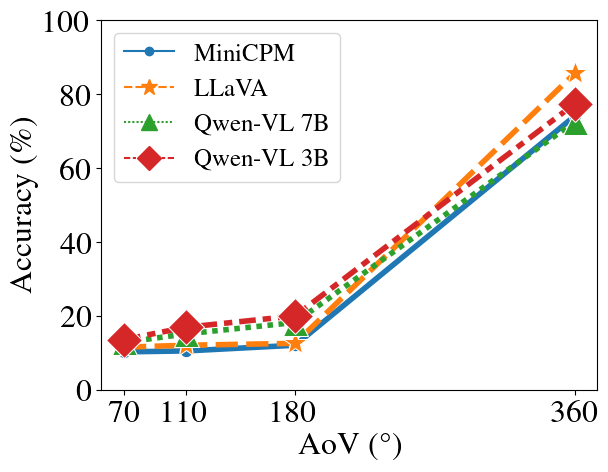

In [215]:
# ---------------------------------------------------------------------------- #
#                             For the Q&A template                             #
# ---------------------------------------------------------------------------- #
def plot_qa_template():
    saveDir = Path(".")/"figs"/f"qa_template"
    saveDir.mkdir(parents=True, exist_ok=True)
    
    filePath = Path(".")/"results_template_question.csv"
    df = pd.read_csv(filePath)
    
    # Step 1: change to plotting format and filter
    df_plot = df
    df_plot["acc"] = df_plot["acc"] * 100
    # ["LLaVA_7", "minicpmo", "qwen", "qwen3"]
    df_plot['model'] = df_plot['model'].replace(['LLaVA_7'], 'MiniCPM')
    df_plot['model'] = df_plot['model'].replace(['minicpmo'], 'LLaVA')
    df_plot['model'] = df_plot['model'].replace(['qwen3'], 'Qwen-VL 3B')
    df_plot['model'] = df_plot['model'].replace(['qwen'], 'Qwen-VL 7B')
    model_order = ['MiniCPM', 'LLaVA', 'Qwen-VL 7B', 'Qwen-VL 3B']
    df_plot['model'] = pd.Categorical(df_plot['model'], categories=model_order, ordered=True)

    # print(df_plot)
    
    # # 整理成 long format，x 用數字 1,5,10
    # df_long = pd.DataFrame({
    #     "metric": [1, 5, 10] * len(df_plot),
    #     "ASR": pd.concat([df_plot["txt_r1_ASR"], df_plot["txt_r5_ASR"], df_plot["txt_r10_ASR"]], ignore_index=True),
    #     "num_of_img": df_plot["num_of_img"].repeat(3).reset_index(drop=True)
    # })

    # 畫 lineplot
    ax = sns.lineplot(x='aov', y='acc',
                    hue= "model",
                    style="model", 
                    data=df_plot, 
                    errorbar=('ci', 95), err_style="bars",
                    palette=color_palette,
                    markers=[".","*","^","D"],
                    markersize=18,
                    lw=4
                    )
    
    
    ax.set(ylim = (0, 100))
    # plt.title("Text Retrieval ASR vs Recall Metric")
    plt.xlabel("AoV (°)")
    plt.ylabel(r"Accuracy (\%)")
    plt.xticks([70, 110, 180, 360])  # 固定 X 軸刻度
    plt.legend(title='', loc='upper left', fontsize="18", ncol=1, markerscale=2)
    
    plt.savefig(f'{saveDir}/qa_template_aov.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{saveDir}/qa_template_aov.eps', dpi=300, bbox_inches='tight')
    plt.show()
    
    
plot_qa_template() 

In [105]:
# ---------------------------------------------------------------------------- #
#                                  Compare AoV                                 #
# ---------------------------------------------------------------------------- #
def read_original_for_aov():
    save_path = Path(".")/"results_aov.csv"
    
    df_all = pd.DataFrame()
    
    # models = ["LLaVA_05", "LLaVA_7", "minicpmo", "qwen", "qwen3"]
    models = ["LLaVA_7", "minicpmo", "qwen", "qwen3"]
    aovs = [360, 180, 110, 70]
    scenes = ["AU", "CUA", "GMU", "GTown", "GTown2", "GWU", "Marymount", "NOVA", "UDC"]
    
    for model in models:
        for aov in aovs:
            for scene in scenes:
                df = pd.DataFrame()
                if scene == "GMU":
                    for base_dir in (Path(f".")/"eva_results"/f"{aov}_{model}"/f"{scene}").iterdir():
                        for d in base_dir.iterdir():
                            seq = d.name
                            input_path = base_dir/f"{seq}"/f"pred_{scene}_{base_dir.name}_{seq}_questions_mcq.jsonl"
                            df_tmp = pd.read_json(input_path, lines=True)[:-1]
                            cols_to_keep = ["qid_number", "question_type", "trigger_type", "bool_ans", "llm_ms"]
                            df_tmp["bool_ans"] = (df_tmp["answer"] == df_tmp["predicted_answer_raw"]).astype(int)
                            df_tmp = df_tmp[cols_to_keep]
                            
                            df_tmp["aov"] = aov
                            df_tmp["model"] = model
                            df_tmp["scene"] = scene
                            df_tmp["seq"] = int(seq)
                            # df_tmp["acc"] = df_tmp["bool_ans"].mean()
                            
                            df = pd.concat([df, df_tmp], ignore_index=True)
                else:
                    base_dir = Path(f".")/"eva_results"/f"{aov}_{model}"/f"{scene}"
                    for d in base_dir.iterdir():
                        seq = d.name
                        input_path = base_dir/f"{seq}"/f"pred_{scene}_{seq}_questions_mcq.jsonl"
                        df_tmp = pd.read_json(input_path, lines=True)[:-1]
                        cols_to_keep = ["qid_number", "question_type", "trigger_type", "bool_ans", "llm_ms"]
                        df_tmp["bool_ans"] = (df_tmp["answer"] == df_tmp["predicted_answer_raw"]).astype(int)
                        df_tmp = df_tmp[cols_to_keep]
                        
                        df_tmp["aov"] = aov
                        df_tmp["model"] = model
                        df_tmp["scene"] = scene
                        df_tmp["seq"] = int(seq)
                        # df_tmp["acc"] = df_tmp["bool_ans"].mean()
                        
                        df = pd.concat([df, df_tmp], ignore_index=True)

                df["acc"] = df["bool_ans"].mean()    
                df_all = pd.concat([df_all, df], ignore_index=True)

    df_all.to_csv(save_path, index=False)
                
read_original_for_aov() 

/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

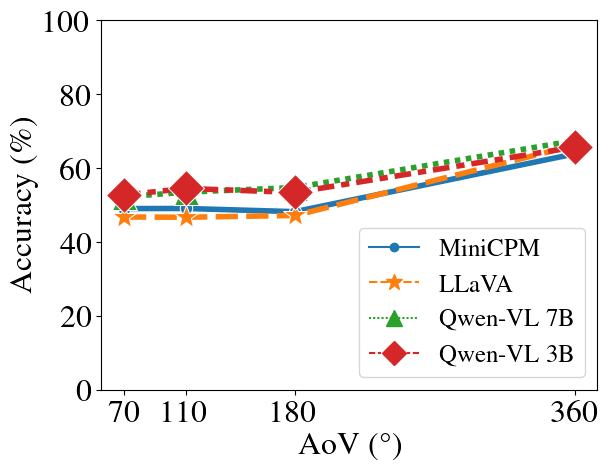

In [216]:
# ---------------------------------------------------------------------------- #
#                                  Compare AoV                                 #
# ---------------------------------------------------------------------------- #
def plot_aov_line():
    saveDir = Path(".")/"figs"/f"aov"
    saveDir.mkdir(parents=True, exist_ok=True)
    
    filePath = Path(".")/"results_aov.csv"
    df = pd.read_csv(filePath)
    
    # Step 1: change to plotting format and filter
    df_plot = df
    df_plot["acc"] = df_plot["acc"] * 100
    # ["LLaVA_7", "minicpmo", "qwen", "qwen3"]
    df_plot['model'] = df_plot['model'].replace(['LLaVA_7'], 'MiniCPM')
    df_plot['model'] = df_plot['model'].replace(['minicpmo'], 'LLaVA')
    df_plot['model'] = df_plot['model'].replace(['qwen3'], 'Qwen-VL 3B')
    df_plot['model'] = df_plot['model'].replace(['qwen'], 'Qwen-VL 7B')
    model_order = ['MiniCPM', 'LLaVA', 'Qwen-VL 7B', 'Qwen-VL 3B', ]
    df_plot['model'] = pd.Categorical(df_plot['model'], categories=model_order, ordered=True)

    # print(df_plot)
    
    # # 整理成 long format，x 用數字 1,5,10
    # df_long = pd.DataFrame({
    #     "metric": [1, 5, 10] * len(df_plot),
    #     "ASR": pd.concat([df_plot["txt_r1_ASR"], df_plot["txt_r5_ASR"], df_plot["txt_r10_ASR"]], ignore_index=True),
    #     "num_of_img": df_plot["num_of_img"].repeat(3).reset_index(drop=True)
    # })

    # 畫 lineplot
    ax = sns.lineplot(x='aov', y='acc',
                    hue= "model",
                    style="model", 
                    data=df_plot, 
                    errorbar=('ci', 95), err_style="bars",
                    palette = color_palette,
                    markers=[".","*","^","D"],
                    markersize=18,
                    lw=4
                    )
    
    ax.set(ylim = (0, 100))
    # plt.title("Text Retrieval ASR vs Recall Metric")
    plt.xlabel("AoV (°)")
    plt.ylabel(r"Accuracy (\%)")
    plt.xticks([70, 110, 180, 360])  # 固定 X 軸刻度
    plt.legend(title='', loc='lower right', fontsize="18", ncol=1, markerscale=2)
    
    plt.savefig(f'{saveDir}/aov_line.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{saveDir}/aov_line.eps', dpi=300, bbox_inches='tight')
    plt.show()
    
    
plot_aov_line() 

/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


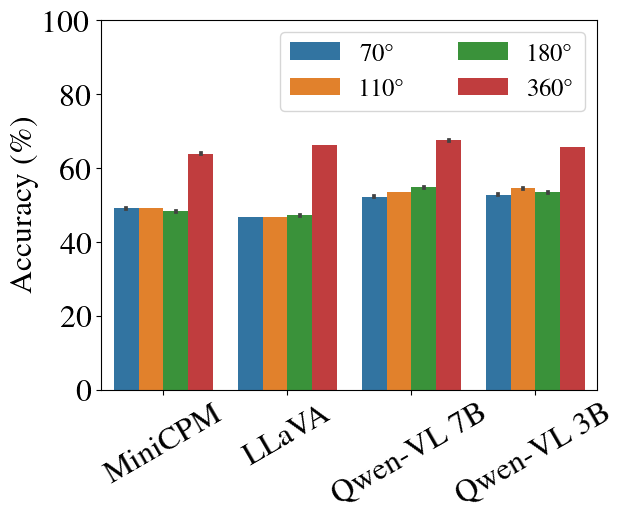

In [217]:
# ---------------------------------------------------------------------------- #
#                                  Compare AoV                                 #
# ---------------------------------------------------------------------------- #
def plot_aov_bar():
    saveDir = Path(".")/"figs"/f"aov"
    saveDir.mkdir(parents=True, exist_ok=True)
    
    filePath = Path(".")/"results_aov.csv"
    df = pd.read_csv(filePath)
    
    # Step 1: change to plotting format and filter
    df_plot = df
    df_plot["acc"] = df_plot["acc"] * 100
    # ["LLaVA_7", "minicpmo", "qwen", "qwen3"]
    df_plot['model'] = df_plot['model'].replace(['LLaVA_7'], 'MiniCPM')
    df_plot['model'] = df_plot['model'].replace(['minicpmo'], 'LLaVA')
    df_plot['model'] = df_plot['model'].replace(['qwen3'], 'Qwen-VL 3B')
    df_plot['model'] = df_plot['model'].replace(['qwen'], 'Qwen-VL 7B')
    model_order = ['MiniCPM', 'LLaVA', 'Qwen-VL 7B', 'Qwen-VL 3B', ]
    df_plot['model'] = pd.Categorical(df_plot['model'], categories=model_order, ordered=True)

    df_plot["aov"] = df_plot["aov"].astype(str)
    df_plot['aov'] = df_plot['aov'].replace(['70'], r"70°")
    df_plot['aov'] = df_plot['aov'].replace(['110'], r"110°")
    df_plot['aov'] = df_plot['aov'].replace(['180'], r"180°")
    df_plot['aov'] = df_plot['aov'].replace(['360'], r"360°")
    aov_order = [r"70°", r"110°", r"180°", r"360°"]
    # print(df_plot)
    
    # 畫 lineplot
    ax = sns.barplot(x='model', y='acc',
                    hue= "aov", hue_order=aov_order,
                    data=df_plot, 
                    errorbar=('ci', 95), 
                    palette=color_palette
                    )

    
    ax.set(ylim = (0, 100))
    # plt.title("Text Retrieval ASR vs Recall Metric")
    plt.xlabel("")
    plt.ylabel(r"Accuracy (\%)")
    # plt.xticks([70, 110, 180, 360])  # 固定 X 軸刻度
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="center")
    plt.legend(title='', loc='upper right', fontsize="18", ncol=2, markerscale=2)
    
    plt.savefig(f'{saveDir}/aov_bar.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{saveDir}/aov_bar.eps', dpi=300, bbox_inches='tight')
    plt.show()
    
    
plot_aov_bar() 

In [112]:
# ---------------------------------------------------------------------------- #
#                                  Categories                                  #
# ---------------------------------------------------------------------------- #
def read_original_for_category():
    save_path = Path(".")/"results_category.csv"
    
    df_all = pd.DataFrame()
    
    # models = ["LLaVA_05", "LLaVA_7", "minicpmo", "qwen", "qwen3"]
    models = ["LLaVA_7", "minicpmo", "qwen", "qwen3"]
    # aovs = [360, 180, 110, 70]
    aovs = [360]
    scenes = ["AU", "CUA", "GMU", "GTown", "GTown2", "GWU", "Marymount", "NOVA", "UDC"]
    categories = ["Object Information", "Navigation", "Safety", "Vicinity Awareness"]
    
    for model in models:
        for aov in aovs:
            for scene in scenes:
                if scene == "GMU":
                    for base_dir in (Path(f".")/"eva_results"/f"{aov}_{model}"/f"{scene}").iterdir():
                        for d in base_dir.iterdir():
                            seq = d.name
                            input_path = base_dir/f"{seq}"/f"pred_{scene}_{base_dir.name}_{seq}_questions_mcq.jsonl"
                            df_tmp = pd.read_json(input_path, lines=True)[:-1]
                            cols_to_keep = ["qid_number", "question_type", "trigger_type", "bool_ans", "llm_ms"]
                            df_tmp["bool_ans"] = (df_tmp["answer"] == df_tmp["predicted_answer_raw"]).astype(int)
                            df_tmp = df_tmp[cols_to_keep]
                            
                            df_tmp["aov"] = aov
                            df_tmp["model"] = model
                            df_tmp["scene"] = scene
                            df_tmp["seq"] = int(seq)
                            
                            df_tmp["acc"] = 0
                            df_tmp["mean_time"] = 0
                            
                            for category in categories:
                                df_tmp.loc[df_tmp["question_type"] == category, "acc"] = df_tmp[df_tmp["question_type"] == category]["bool_ans"].mean()
                                df_tmp.loc[df_tmp["question_type"] == category, "mean_time"] = df_tmp[df_tmp["question_type"] == category]["llm_ms"].mean()
                            
                            df_all = pd.concat([df_all, df_tmp], ignore_index=True)
                else:
                    base_dir = Path(f".")/"eva_results"/f"{aov}_{model}"/f"{scene}"
                    for d in base_dir.iterdir():
                        seq = d.name
                        input_path = base_dir/f"{seq}"/f"pred_{scene}_{seq}_questions_mcq.jsonl"
                        df_tmp = pd.read_json(input_path, lines=True)[:-1]
                        cols_to_keep = ["qid_number", "question_type", "trigger_type", "bool_ans", "llm_ms"]
                        df_tmp["bool_ans"] = (df_tmp["answer"] == df_tmp["predicted_answer_raw"]).astype(int)
                        df_tmp = df_tmp[cols_to_keep]
                        
                        df_tmp["aov"] = aov
                        df_tmp["model"] = model
                        df_tmp["scene"] = scene
                        df_tmp["seq"] = int(seq)
                        
                        for category in categories:
                            df_tmp.loc[df_tmp["question_type"] == category, "acc"] = df_tmp[df_tmp["question_type"] == category]["bool_ans"].mean()
                            df_tmp.loc[df_tmp["question_type"] == category, "mean_time"] = df_tmp[df_tmp["question_type"] == category]["llm_ms"].mean()
                            
                        df_all = pd.concat([df_all, df_tmp], ignore_index=True)

    df_all.to_csv(save_path, index=False)
                
read_original_for_category() 

/var/folders/dg/8kj2178127j0gbm263pw11d40000gn/T/ipykernel_5879/2285355087.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2631578947368421' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_tmp.loc[df_tmp["question_type"] == category, "acc"] = df_tmp[df_tmp["question_type"] == category]["bool_ans"].mean()
/var/folders/dg/8kj2178127j0gbm263pw11d40000gn/T/ipykernel_5879/2285355087.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '298.42368421052635' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_tmp.loc[df_tmp["question_type"] == category, "mean_time"] = df_tmp[df_tmp["question_type"] == category]["llm_ms"].mean()
/var/folders/dg/8kj2178127j0gbm263pw11d40000gn/T/ipykernel_5879/2285355087.py:38: FutureWarning: Setting an item of incompatible dtype is 

/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


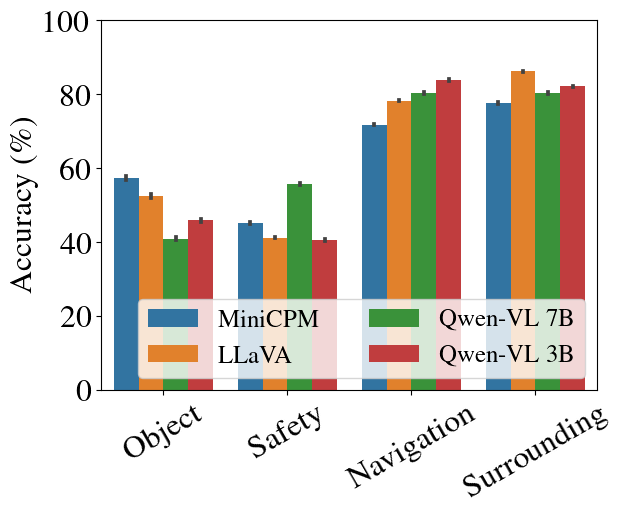

In [218]:
# ---------------------------------------------------------------------------- #
#                                  Categories                                  #
# ---------------------------------------------------------------------------- #
def plot_category_acc_bar():
    saveDir = Path(".")/"figs"/f"category"
    saveDir.mkdir(parents=True, exist_ok=True)
    
    filePath = Path(".")/"results_category.csv"
    df = pd.read_csv(filePath)
    
    # Step 1: change to plotting format and filter
    df_plot = df
    df_plot["acc"] = df_plot["acc"] * 100
    # ["LLaVA_7", "minicpmo", "qwen", "qwen3"]
    df_plot['model'] = df_plot['model'].replace(['LLaVA_7'], 'MiniCPM')
    df_plot['model'] = df_plot['model'].replace(['minicpmo'], 'LLaVA')
    df_plot['model'] = df_plot['model'].replace(['qwen3'], 'Qwen-VL 3B')
    df_plot['model'] = df_plot['model'].replace(['qwen'], 'Qwen-VL 7B')
    model_order = ['MiniCPM', 'LLaVA', 'Qwen-VL 7B', 'Qwen-VL 3B']
    df_plot['model'] = pd.Categorical(df_plot['model'], categories=model_order, ordered=True)
    
    df_plot['question_type'] = df_plot['question_type'].replace(['Object Information'], 'Object')
    df_plot['question_type'] = df_plot['question_type'].replace(['Safety'], 'Safety')
    df_plot['question_type'] = df_plot['question_type'].replace(['Navigation'], 'Navigation')
    df_plot['question_type'] = df_plot['question_type'].replace(['Vicinity Awareness'], 'Surrounding')
    category_order = ['Object', 'Safety', 'Navigation', 'Surrounding']
    df_plot['question_type'] = pd.Categorical(df_plot['question_type'], categories=category_order, ordered=True)

    df_plot["aov"] = df_plot["aov"].astype(str)
    df_plot['aov'] = df_plot['aov'].replace(['70'], r"70°")
    df_plot['aov'] = df_plot['aov'].replace(['110'], r"110°")
    df_plot['aov'] = df_plot['aov'].replace(['180'], r"180°")
    df_plot['aov'] = df_plot['aov'].replace(['360'], r"360°")
    aov_order = [r"70°", r"110°", r"180°", r"360°"]
    # print(df_plot)
    
    # 畫 lineplot
    ax = sns.barplot(x='question_type', y='acc',
                    hue= "model", hue_order=model_order,
                    data=df_plot, 
                    errorbar=('ci', 95), 
                    palette=color_palette
                    )

    
    ax.set(ylim = (0, 100))
    # plt.title("Text Retrieval ASR vs Recall Metric")
    plt.xlabel("")
    plt.ylabel(r"Accuracy (\%)")
    # plt.xticks([70, 110, 180, 360])  # 固定 X 軸刻度
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="center")
    plt.legend(title='', loc='lower right', fontsize="18", ncol=2, markerscale=2)
    
    plt.savefig(f'{saveDir}/model_acc_bar.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{saveDir}/model_acc_bar.eps', dpi=300, bbox_inches='tight')
    plt.show()
    
    
plot_category_acc_bar() 

/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


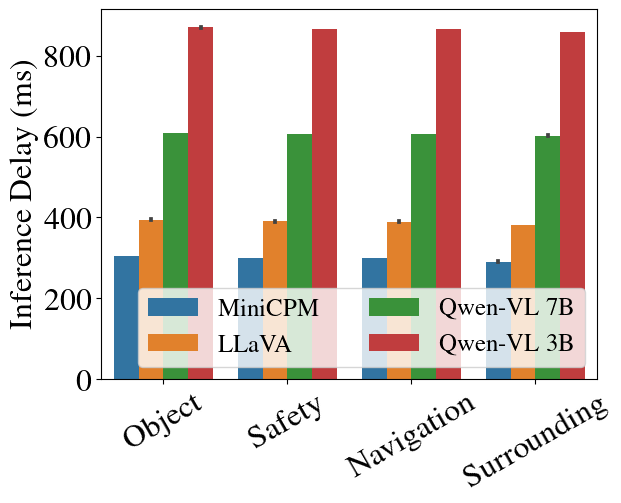

In [220]:
# ---------------------------------------------------------------------------- #
#                                  Categories                                  #
# ---------------------------------------------------------------------------- #
def plot_category_time_bar():
    saveDir = Path(".")/"figs"/f"category"
    saveDir.mkdir(parents=True, exist_ok=True)
    
    filePath = Path(".")/"results_category.csv"
    df = pd.read_csv(filePath)
    
    # Step 1: change to plotting format and filter
    df_plot = df
    df_plot["acc"] = df_plot["acc"] * 100
    # ["LLaVA_7", "minicpmo", "qwen", "qwen3"]
    df_plot['model'] = df_plot['model'].replace(['LLaVA_7'], 'MiniCPM')
    df_plot['model'] = df_plot['model'].replace(['minicpmo'], 'LLaVA')
    df_plot['model'] = df_plot['model'].replace(['qwen3'], 'Qwen-VL 3B')
    df_plot['model'] = df_plot['model'].replace(['qwen'], 'Qwen-VL 7B')
    model_order = ['MiniCPM', 'LLaVA', 'Qwen-VL 7B', 'Qwen-VL 3B']
    df_plot['model'] = pd.Categorical(df_plot['model'], categories=model_order, ordered=True)
    
    df_plot['question_type'] = df_plot['question_type'].replace(['Object Information'], 'Object')
    df_plot['question_type'] = df_plot['question_type'].replace(['Safety'], 'Safety')
    df_plot['question_type'] = df_plot['question_type'].replace(['Navigation'], 'Navigation')
    df_plot['question_type'] = df_plot['question_type'].replace(['Vicinity Awareness'], 'Surrounding')
    category_order = ['Object', 'Safety', 'Navigation', 'Surrounding']
    df_plot['question_type'] = pd.Categorical(df_plot['question_type'], categories=category_order, ordered=True)

    df_plot["aov"] = df_plot["aov"].astype(str)
    df_plot['aov'] = df_plot['aov'].replace(['70'], r"70°")
    df_plot['aov'] = df_plot['aov'].replace(['110'], r"110°")
    df_plot['aov'] = df_plot['aov'].replace(['180'], r"180°")
    df_plot['aov'] = df_plot['aov'].replace(['360'], r"360°")
    aov_order = [r"70°", r"110°", r"180°", r"360°"]
    # print(df_plot)
    
    # 畫 lineplot
    ax = sns.barplot(x='question_type', y='mean_time',
                    hue= "model", hue_order=model_order,
                    data=df_plot, 
                    errorbar=('ci', 95), 
                    palette=color_palette
                    )
    
    # ax.set(ylim = (0, 100))
    # plt.title("Text Retrieval ASR vs Recall Metric")
    plt.xlabel("")
    plt.ylabel(r"Inference Delay (ms)")
    # plt.xticks([70, 110, 180, 360])  # 固定 X 軸刻度
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="center")
    plt.legend(title='', loc='lower right', fontsize="18", ncol=2, markerscale=2)
    
    plt.savefig(f'{saveDir}/model_delay_bar.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{saveDir}/model_delay_bar.eps', dpi=300, bbox_inches='tight')
    plt.show()
    
    
plot_category_time_bar() 

/var/folders/dg/8kj2178127j0gbm263pw11d40000gn/T/ipykernel_5879/1939255867.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for model, g in df_plot.groupby("model"):
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


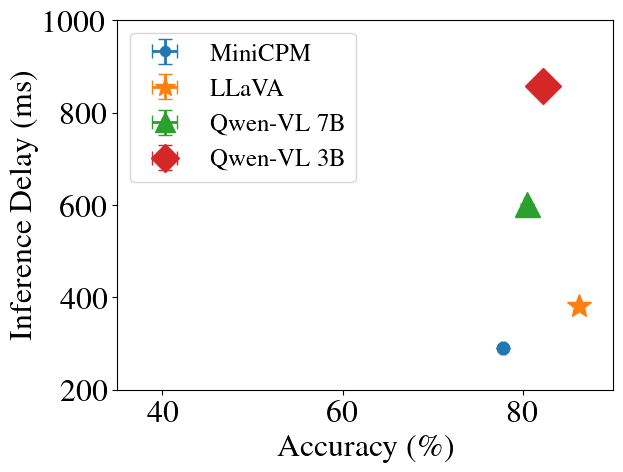

In [228]:
# ---------------------------------------------------------------------------- #
#                                  Categories                                  #
# ---------------------------------------------------------------------------- #
import scipy.stats as st
def mean_ci(series):
    mean = series.mean()
    ci95 = st.t.interval(0.95, len(series)-1, loc=mean, scale=st.sem(series))
    # Return mean and half-width of CI
    return mean, (ci95[1] - ci95[0]) / 2

def plot_category_acc_delay(type):
    saveDir = Path(".")/"figs"/f"category"
    saveDir.mkdir(parents=True, exist_ok=True)
    
    filePath = Path(".")/"results_category.csv"
    df = pd.read_csv(filePath)
    
    # Step 1: change to plotting format and filter
    df_plot = df
    df_plot["acc"] = df_plot["acc"] * 100
    # ["LLaVA_7", "minicpmo", "qwen", "qwen3"]
    df_plot['model'] = df_plot['model'].replace(['LLaVA_7'], 'MiniCPM')
    df_plot['model'] = df_plot['model'].replace(['minicpmo'], 'LLaVA')
    df_plot['model'] = df_plot['model'].replace(['qwen3'], 'Qwen-VL 3B')
    df_plot['model'] = df_plot['model'].replace(['qwen'], 'Qwen-VL 7B')
    model_order = ['MiniCPM', 'LLaVA', 'Qwen-VL 7B', 'Qwen-VL 3B']
    df_plot['model'] = pd.Categorical(df_plot['model'], categories=model_order, ordered=True)
    
    df_plot['question_type'] = df_plot['question_type'].replace(['Object Information'], 'Object')
    df_plot['question_type'] = df_plot['question_type'].replace(['Safety'], 'Safety')
    df_plot['question_type'] = df_plot['question_type'].replace(['Navigation'], 'Navigation')
    df_plot['question_type'] = df_plot['question_type'].replace(['Vicinity Awareness'], 'Surrounding')
    category_order = ['Object', 'Safety', 'Navigation', 'Surrounding']
    df_plot['question_type'] = pd.Categorical(df_plot['question_type'], categories=category_order, ordered=True)

    df_plot["aov"] = df_plot["aov"].astype(str)
    df_plot['aov'] = df_plot['aov'].replace(['70'], r"70°")
    df_plot['aov'] = df_plot['aov'].replace(['110'], r"110°")
    df_plot['aov'] = df_plot['aov'].replace(['180'], r"180°")
    df_plot['aov'] = df_plot['aov'].replace(['360'], r"360°")
    aov_order = [r"70°", r"110°", r"180°", r"360°"]
    # print(df_plot)
    
    df_plot = df_plot[df_plot['question_type'] == type]
    
    # 畫 lineplot
    # Plot scatter with error bars
    # Aggregate by model
    results = []
    for model, g in df_plot.groupby("model"):
        acc_mean, acc_ci = mean_ci(g["acc"])
        delay_mean, delay_ci = mean_ci(g["mean_time"])
        results.append({
            "model": model,
            "acc_mean": acc_mean,  # convert to %
            "acc_ci": acc_ci,
            "delay_mean": delay_mean,
            "delay_ci": delay_ci
        })
    
    df_plot = pd.DataFrame(results)
    markers=[".","*","^","D"]
    marker_map = dict(zip(df_plot["model"].unique(), markers))
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    for model in df_plot["model"].unique():
        row = df_plot[df_plot["model"] == model].iloc[0]
        ax.errorbar(
            row["acc_mean"], row["delay_mean"],
            xerr=row["acc_ci"], yerr=row["delay_ci"],
            fmt=marker_map[model], markersize=18,
            capsize=5, elinewidth=2, label=model
        )
    
    ax.set(xlim = (35, 90))
    ax.set(ylim = (200, 1000))
    plt.xlabel("Accuracy (\%)")
    plt.ylabel("Inference Delay (ms)")
    # # plt.xticks([70, 110, 180, 360])  # 固定 X 軸刻度
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="center")
    
    # plt.legend(title='', loc='upper right', fontsize="18", ncol=1, markerscale=0.8)
    # plt.legend(title='', loc='upper right', fontsize="18", ncol=1, markerscale=0.8)
    plt.legend(title='', loc='upper left', fontsize="18", ncol=1, markerscale=0.8)
    # plt.legend(title='', loc='upper left', fontsize="18", ncol=1, markerscale=0.8)
    
    plt.savefig(f'{saveDir}/category_acc_delay_{type}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{saveDir}/category_acc_delay_{type}.eps', dpi=300, bbox_inches='tight')
    plt.show()
    
# for type in ['Object', 'Safety', 'Navigation', 'Surrounding']:
#     plot_category_acc_delay(type)

plot_category_acc_delay("Surrounding") 

/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/syjintw/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


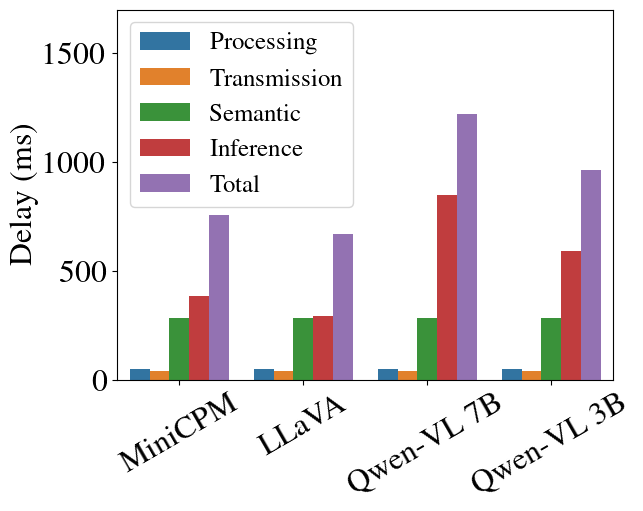

In [222]:
def delay_bar():
    saveDir = Path(".")/"figs"/f"delay"
    saveDir.mkdir(parents=True, exist_ok=True)
    
    data = [
            ["MiniCPM", "Processing", 48],
            ["MiniCPM", "Transmission", 41],
            ["MiniCPM", "Semantic", 285],
            ["MiniCPM", "Inference", 383],
            ["MiniCPM", "Total", 757],
            ["Qwen-VL 3B", "Processing", 48],
            ["Qwen-VL 3B", "Transmission", 41],
            ["Qwen-VL 3B", "Semantic", 285],
            ["Qwen-VL 3B", "Inference", 590],
            ["Qwen-VL 3B", "Total", 964],
            ["Qwen-VL 7B", "Processing", 48],
            ["Qwen-VL 7B", "Transmission", 41],
            ["Qwen-VL 7B", "Semantic", 285],
            ["Qwen-VL 7B", "Inference", 847],
            ["Qwen-VL 7B", "Total", 1221],
            ["LLaVA", "Processing", 48],
            ["LLaVA", "Transmission", 41],
            ["LLaVA", "Semantic", 285],
            ["LLaVA", "Inference", 294],
            ["LLaVA", "Total", 668]
            ]
    df = pd.DataFrame(data, columns=["model", "delay_type", "time"])
    
    df_plot = df
    model_order = ['MiniCPM', 'LLaVA', 'Qwen-VL 7B', 'Qwen-VL 3B']
    df_plot['model'] = pd.Categorical(df_plot['model'], categories=model_order, ordered=True)
    delay_type_order = ["Processing", "Transmission", "Semantic", "Inference", "Total"]
    
    # 畫 lineplot
    ax = sns.barplot(x='model', y='time',
                    hue= "delay_type", hue_order=delay_type_order,
                    data=df_plot, 
                    errorbar=('ci', 95), 
                    palette=color_palette
                    )

    
    ax.set(ylim = (0, 1700))
    # plt.title("Text Retrieval ASR vs Recall Metric")
    plt.xlabel("")
    plt.ylabel("Delay (ms)")
    # plt.xticks([70, 110, 180, 360])  # 固定 X 軸刻度
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="center")
    plt.legend(title='', loc='upper left', fontsize="18", ncol=1, markerscale=2)
    
    plt.savefig(f'{saveDir}/delay_bar.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{saveDir}/delay_bar.eps', dpi=300, bbox_inches='tight')
    plt.show()
    
delay_bar()
